In [1]:
# 波士顿房价数据集
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()


In [2]:
train_data.shape

(404, 13)

In [3]:
test_data.shape

(102, 13)

准备数据

In [4]:
# 对每个特征进行标准化
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

构建网络

In [5]:
# 模型定义
from keras import models
from keras import layers

def build_model():
    """
    将一个同一个模型多次实例化，用一个函数来构建模型
    :return:
    """
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    # 只有一个单元，没有激活，是一个线性层，标题回归
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

利用K折验证来验证你的方法

In [6]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_score = []

for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_data[i * num_val_samples: (i + 1) * num_val_samples]

    partial_train_data = np.concatenate(
        [train_data[: i * num_val_samples],
         train_data[(i * 1) * num_val_samples:]],
        axis=0
    )

    partial_train_targets = np.concatenate(
        [train_targets[: i * num_val_samples],
         train_targets[(i * 1) * num_val_samples:]],
        axis=0
    )

    # 构建Keras模型
    model = build_model()
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=1, verbose=0)

    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_score.append(val_mae)


processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [8]:
all_score

[21.800548553466797,
 21.327817916870117,
 20.778783798217773,
 24.349834442138672]

In [9]:
np.mean(all_score)

22.06424617767334

保存每折的验证结果

In [11]:
num_epochs = 500
all_mae_history = []

for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    partial_train_data = np.concatenate(
        [train_data[: i * num_val_samples],
         train_data[(i * 1) * num_val_samples:]],
        axis=0
    )

    partial_train_targets = np.concatenate(
        [train_targets[: i * num_val_samples],
         train_targets[(i * 1) * num_val_samples:]],
        axis=0
    )

    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)

    mae_history = history.history['val_mae']
    all_mae_history.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


计算每个轮次中的K折验证分数平均值

In [12]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_history]) for i in range(num_epochs)
]

绘制验证分数

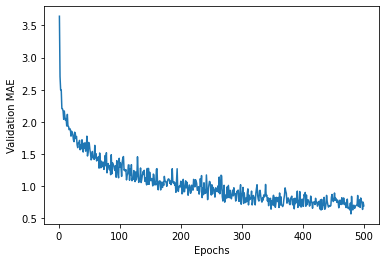

In [13]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

绘制验证分数（删除前10个数据点）

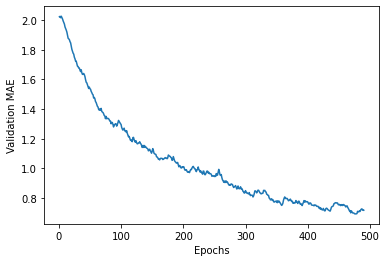

In [17]:
def smooth_curve(points, factor=0.9):
    smooth_points = []
    for point in points:
        if smooth_points:
            previous = smooth_points[-1]
            smooth_points.append(previous * factor + point * (1 - factor))
        else:
            smooth_points.append(point)
    return smooth_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

训练最终模型

In [18]:
model = build_model()
model.fit(train_data, train_targets,
          epochs=80, batch_size=16, verbose=0)

test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)


4/4 [==============================] - 0s 676us/step - loss: 17.1280 - mae: 2.5414
